In [2]:
import numpy as np
import random
import time
from datetime import timedelta
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.layers import BatchNormalization
from keras.callbacks import TensorBoard,ModelCheckpoint
from keras import backend as K
from keras.metrics import top_k_categorical_accuracy
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Activation
import tensorflow.keras.backend as K
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers import BatchNormalization
from keras.optimizers import Adam
import os

In [5]:
#K.set_image_data_format('channels_first')
K.set_image_data_format('channels_last')

print(K.backend(), K.image_data_format())

tensorflow channels_last


In [7]:
batch_size = 128 #128
samples_per_epoch = 10
num_classes = 4
epochs = 20 #40
class_names = ["voip", "video", "file transfer", "chat"]

# input hist dimensions
height, width = 1500, 1500
input_shape = (1, height, width)
# input_shape = (height, width,1)

#input_shape = (height, width)
MODEL_NAME = "FlowPic"

In [8]:
# Reading the data from the uploaded in Kaggle's input
path = "/kaggle/input/vpn-non-vpn-iscx-2016-npy"
X_train = np.load('/kaggle/input/vpn-non-vpn-iscx-2016-npy/reg_X_train.npy')#, mmap_mode='r')
y_train_true = np.load('/kaggle/input/vpn-non-vpn-iscx-2016-npy/reg_y_train.npy')#, mmap_mode='r')
X_val = np.load('/kaggle/input/vpn-non-vpn-iscx-2016-npy/reg_X_val.npy')#, mmap_mode='r')
y_val_true = np.load('/kaggle/input/vpn-non-vpn-iscx-2016-npy/reg_y_val.npy')#, mmap_mode='r')

X_test = np.load('/kaggle/input/vpn-non-vpn-iscx-2016-npy/reg_X_test.npy')#, mmap_mode='r')
y_test_true = np.load('/kaggle/input/vpn-non-vpn-iscx-2016-npy/reg_y_test.npy')#, mmap_mode='r')


In [9]:
# X_train = np.expand_dims(X_train, axis=-1) # for (420, 1500, 1500 ,1) 
X_train = np.expand_dims(X_train, axis=1) # for (420, 1, 1500, 1500)

# X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
X_val = np.expand_dims(X_val, axis=1)
X_test = np.expand_dims(X_test, axis=1)
print(X_train.shape)  # Should print (420, 1, 1500, 1500)

(420, 1, 1500, 1500)


In [10]:
# X_train.shape, X_val.shape, y_train.shape, y_val.shape
X_train.shape, X_val.shape, y_train_true.shape, y_val_true.shape, X_test.shape, y_test_true.shape

((420, 1, 1500, 1500),
 (141, 1, 1500, 1500),
 (420,),
 (141,),
 (141, 1, 1500, 1500),
 (141,))

In [11]:
# # Transpose the data from (1, 1500, 1500) to (1500, 1500, 1)
# X_train = np.transpose(X_train, (0, 2, 3, 1))  # (samples, channels, height, width) -> (samples, height, width, channels)
# X_val = np.transpose(X_val, (0, 2, 3, 1))

# print(X_train.shape)  # Should print (num_samples, 1500, 1500, 1)
# print(X_val.shape)

In [12]:
print(y_train_true[0:70])
print(y_val_true[0:70])
print(y_test_true[0:70])

[1. 2. 2. 1. 2. 2. 1. 1. 2. 0. 2. 2. 1. 2. 1. 1. 2. 1. 2. 0. 2. 2. 0. 2.
 1. 2. 2. 2. 3. 2. 0. 2. 2. 2. 1. 2. 2. 3. 2. 0. 2. 2. 1. 3. 2. 2. 1. 1.
 2. 2. 2. 2. 2. 2. 1. 1. 1. 2. 1. 1. 2. 2. 2. 0. 2. 3. 1. 1. 3. 2.]
[2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 1. 1. 2. 1. 2. 2. 2.
 0. 0. 0. 0. 2. 2. 3. 1. 2. 2. 2. 0. 3. 1. 2. 0. 2. 2. 2. 2. 1. 2. 2. 1.
 3. 0. 0. 2. 1. 2. 1. 2. 0. 1. 1. 2. 0. 0. 2. 2. 2. 2. 2. 1. 2. 2.]
[2. 1. 0. 3. 2. 2. 2. 3. 3. 2. 2. 2. 2. 2. 1. 2. 1. 0. 1. 2. 2. 2. 2. 1.
 2. 2. 0. 3. 3. 3. 2. 2. 1. 0. 2. 3. 1. 2. 2. 2. 2. 2. 2. 3. 0. 2. 1. 2.
 2. 3. 2. 2. 2. 2. 2. 2. 2. 1. 1. 0. 0. 2. 2. 2. 2. 1. 2. 0. 3. 1.]


In [14]:
# Making the classes for the CNN. Exmp 0 = [1,0,0,0], 1 = [0,1,0,0]
y_train = to_categorical(y_train_true, num_classes)
y_val = to_categorical(y_val_true, num_classes)
y_test = to_categorical(y_test_true, num_classes)
print(y_train[0:10])
print (y_val[0:10])
print (y_test[0:10])
print(y_train.shape, y_val.shape, y_test.shape)

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
(420, 4) (141, 4) (141, 4)


In [15]:
# Define custom metrics (if required)
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * ((prec * rec) / (prec + rec + K.epsilon()))
def top_2_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2) 

In [16]:
# Input data is already in (batch_size, channels, height, width)
print(X_train.shape)  # Should be (num_samples, 1, 1500, 1500)

#Model definition

# model = Sequential()
# model.add(Conv2D(10, kernel_size=(10, 10), strides=5, padding="same", data_format='channels_last', input_shape=input_shape))
# print(model.output_shape)
# model.add(MaxPooling2D(pool_size=(2, 2), padding="same", data_format='channels_last', input_shape=input_shape))
# print(model.output_shape)
# model.add(Conv2D(20, kernel_size=(10, 10), strides=5, padding="same", data_format='channels_last', input_shape=input_shape))
# print(model.output_shape)
# model.add(Dropout(0.25))
# model.add(MaxPooling2D(pool_size=(2, 2), padding="same", data_format='channels_last', input_shape=input_shape))
# print(model.output_shape)
# model.add(Flatten())
# print(model.output_shape)
# model.add(Dense(64, activation='relu'))
# print(model.output_shape)
# model.add(Dropout(0.5))
# print(model.output_shape)
# model.add(Dense(num_classes, activation='softmax'))
# print(model.output_shape)
model = Sequential()
model.add(Conv2D(10, kernel_size=(10, 10), strides=5, padding="same", data_format='channels_last', input_shape=input_shape))
model.add(Activation('relu'))
print(model.output_shape)
model.add(MaxPooling2D(pool_size=(2, 2), padding="same", data_format='channels_last'))
print(model.output_shape)
model.add(Conv2D(20, kernel_size=(10, 10), strides=5, padding="same", data_format='channels_last'))
model.add(Activation('relu'))
print(model.output_shape)
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2), padding="same", data_format='channels_last'))
print(model.output_shape)
model.add(Flatten())
print(model.output_shape)
model.add(Dense(64, activation='relu'))
print(model.output_shape)
model.add(Dropout(0.5))
print(model.output_shape)
model.add(Dense(num_classes, activation='softmax'))
print(model.output_shape)

from tensorflow.keras.metrics import Precision, Recall

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy',top_2_categorical_accuracy ,Precision(), Recall()]
)

# Print model summary to check layer dimensions
model.summary()

# Print class distribution
print("Class distribution:")
# Fix the class distribution print
unique, counts = np.unique(y_train_true, return_counts=True)
for class_idx, count in zip(unique, counts):
    print(f"Class {class_names[int(class_idx)]}: {count}")

(420, 1, 1500, 1500)
(None, 1, 300, 10)
(None, 1, 150, 10)
(None, 1, 30, 20)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(None, 1, 15, 20)
(None, 300)
(None, 64)
(None, 64)
(None, 4)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 1, 300, 10)          │       1,500,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1, 300, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 1, 150, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 1, 30, 20)           │          20,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1, 30, 20)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 30, 20)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 15, 20)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,539,554 (5.87 MB)

 Trainable params: 1,539,554 (5.87 MB)

 Non-trainable params: 0 (0.00 B)

Class distribution:
Class voip: 41
Class video: 89
Class file transfer: 235
Class chat: 55


In [17]:

print(K.image_data_format())  # Should print "channels_last"
if K.image_data_format() != "channels_last":
    K.set_image_data_format("channels_last")

channels_last


In [22]:
# Define callbacks
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=5,               # Number of epochs with no improvement after which training will stop
        restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
    ),
    
    # Reduce learning rate when a metric has stopped improving
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,              # Factor by which the learning rate will be reduced
        patience=3,              # Number of epochs with no improvement after which learning rate will be reduced
        min_lr=1e-6
    ),
    
    # Your existing TensorBoard callback
    TensorBoard(log_dir='./Graph', histogram_freq=1, write_graph=True, write_images=True)
]

In [23]:
# Define TensorBoard
#tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=1, write_graph=True, write_images=True)

# Define ModelCheckpoint
# checkpointer_loss = ModelCheckpoint(filepath=MODEL_NAME + '_loss.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
# checkpointer_acc = ModelCheckpoint(monitor='val_acc', filepath=MODEL_NAME + '_acc.hdf5', verbose=1, save_best_only=True, save_weights_only=True)

#Define generator
def generator(features, labels, batch_size):
    index = 0
    while True:
        index += batch_size
        if index >= len(features):
            batch_features = np.append(features[index - batch_size:len(features)], features[0:index - len(features)], axis=0)
            batch_labels = np.append(labels[index - batch_size:len(features)], labels[0:index - len(features)], axis=0)
            index -= len(features)
            yield batch_features, batch_labels
        else:
            yield features[index - batch_size:index], labels[index - batch_size:index]

# Start timing
start_time = time.time()


# Train the model
history = model.fit(
    generator(X_train, y_train, batch_size),
    epochs=epochs,
    steps_per_epoch=samples_per_epoch, #// batch_size,
    verbose=1,
    callbacks = callbacks,
    validation_data=(X_val, y_val)
)

# Calculate training time
training_time = time.time() - start_time
print(f'Total training time: {timedelta(seconds=training_time)}')


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 132s 13s/step - accuracy: 0.4360 - loss: 1.3179 - precision: 0.4415 - recall: 0.0267 - top_2_categorical_accuracy: 0.6445 - val_accuracy: 0.5745 - val_loss: 0.8387 - val_precision: 0.9836 - val_recall: 0.4255 - val_top_2_categorical_accuracy: 0.7660 - learning_rate: 0.0010
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 126s 13s/step - accuracy: 0.6323 - loss: 0.7224 - precision: 0.9656 - recall: 0.5002 - top_2_categorical_accuracy: 0.8122 - val_accuracy: 0.7021 - val_loss: 0.5425 - val_precision: 0.9892 - val_recall: 0.6525 - val_top_2_categorical_accuracy: 0.7872 - learning_rate: 0.0010
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 125s 13s/step - accuracy: 0.7581 - loss: 0.4989 - precision: 0.9800 - recall: 0.6423 - top_2_categorical_accuracy: 0.8376 - val_accuracy: 0.7589 - val_loss: 0.4489 - val_precision: 0.9592 - val_recall: 0.6667 - val_top_2_categorical_accuracy: 0.8582 - learning_rate: 0.0010
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 127s 13s/step - accuracy: 

In [24]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


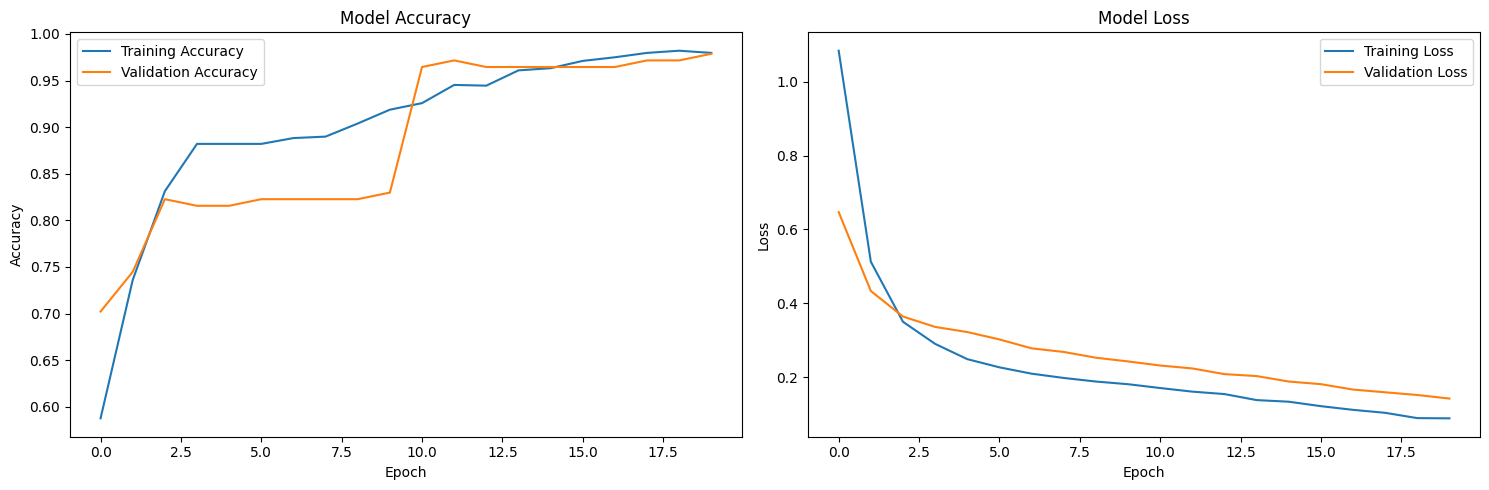

In [65]:
# Plot the training history
plot_training_history(history)

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'top_2_categorical_accuracy', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall', 'val_top_2_categorical_accuracy', 'learning_rate'])


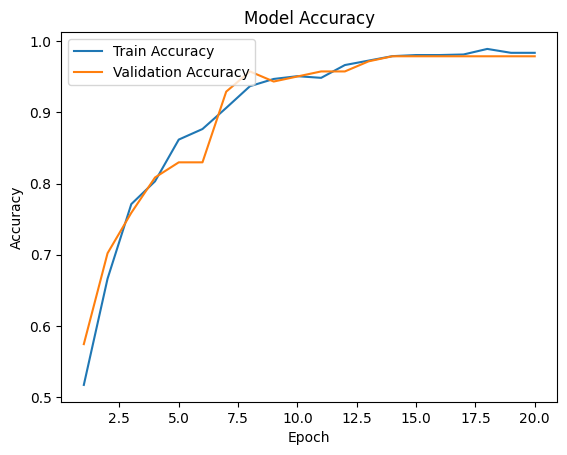

In [25]:

# List all available keys in history
print(history.history.keys())

# Define x-axis values (epochs)
x = np.asarray(range(1, epochs + 1))

# Plot accuracy
plt.figure()
plt.plot(x, history.history['accuracy'], label='Train Accuracy')  # Use 'accuracy' instead of 'acc'
plt.plot(x, history.history['val_accuracy'], label='Validation Accuracy')  # Use 'val_accuracy' instead of 'val_acc'
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [26]:
# Get predictions (probabilities for each class)
y_val_probabilities = model.predict(X_val, verbose=1)

# Convert probabilities to class predictions
y_val_predictions = np.argmax(y_val_probabilities, axis=1)

print(y_val_predictions)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 587ms/step
[2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 3 3 1 1 2 1 2 2 2 0 0 0 0 2 2 3 1 2 2 2 0 3
 1 2 0 2 2 2 2 1 2 2 1 3 0 0 2 1 2 1 2 0 1 1 2 0 0 2 2 2 2 2 1 2 2 1 1 3 2
 1 1 3 2 1 3 2 3 0 2 2 3 1 2 2 2 2 1 2 0 2 2 2 2 2 2 2 0 2 2 2 2 0 0 2 3 2
 3 2 2 0 2 2 0 2 0 2 2 0 3 2 2 1 1 2 2 1 3 2 2 1 2 3 2 2 2 1]


Confusion matrix, without normalization
[[19  0  0  0]
 [ 1 25  0  1]
 [ 0  0 80  0]
 [ 0  0  1 14]]
Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.04 0.93 0.   0.04]
 [0.   0.   1.   0.  ]
 [0.   0.   0.07 0.93]]


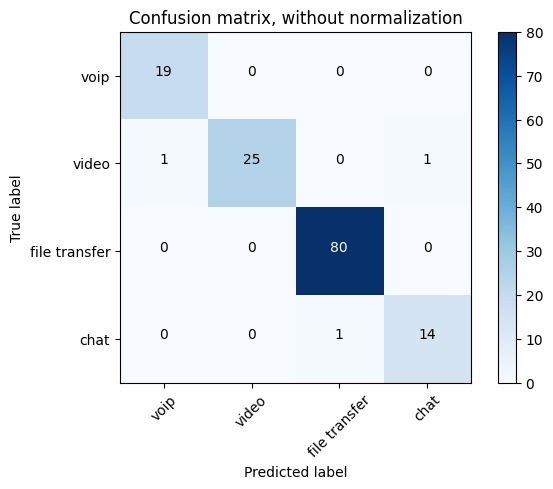

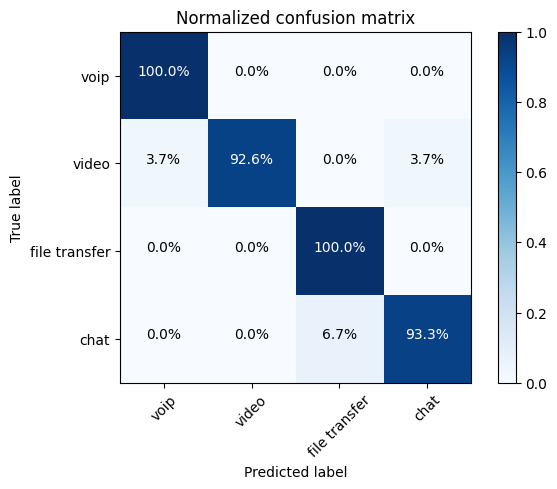

In [27]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          fname='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, format(cm[i, j]*100, fmt) + '%',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")    
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(fname, bbox_inches='tight', pad_inches=1)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val_true, y_val_predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      fname=MODEL_NAME + "_" + 'Confusion_matrix_without_normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix',
                      fname=MODEL_NAME + "_" + 'Normalized_confusion_matrix')

plt.show()

In [28]:
y_val_true = np.argmax(y_val, axis=1)

# Compare predictions with true labels
accuracy = np.mean(y_val_predictions == y_val_true)
print(f"Validation Accuracy: {accuracy:.2f}")

Validation Accuracy: 0.98


In [29]:
from sklearn.metrics import classification_report, accuracy_score

# Print classification report
print(classification_report(y_val_true, y_val_predictions))

# Calculate and print accuracy as a percentage
accuracy = accuracy_score(y_val_true, y_val_predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      0.93      0.96        27
           2       0.99      1.00      0.99        80
           3       0.93      0.93      0.93        15

    accuracy                           0.98       141
   macro avg       0.97      0.96      0.97       141
weighted avg       0.98      0.98      0.98       141

Accuracy: 97.87%


### Checking on the X_test that wasn't in the training 

In [30]:
y_test = to_categorical(y_test_true, num_classes)
print(y_test[0:10])
print(y_test.shape)

[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
(141, 4)


In [31]:
X_test.shape

(141, 1, 1500, 1500)

In [32]:
# # Remove extra dimension
# X_test = X_test.squeeze(axis=2)
# print(f"New shape: {X_test.shape}")  # Should be (141, 1, 1500, 1500)
# # X_test = X_test.reshape(141, 1, 1500, 1500)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 570ms/step
Total training time: 0:00:05.221481

Classification Report:
               precision    recall  f1-score   support

         voip       0.92      0.96      0.94        23
        video       0.97      0.97      0.97        30
file transfer       0.99      0.99      0.99        72
         chat       1.00      0.94      0.97        16

     accuracy                           0.97       141
    macro avg       0.97      0.96      0.96       141
 weighted avg       0.97      0.97      0.97       141

Normalized confusion matrix
[[0.96 0.04 0.   0.  ]
 [0.03 0.97 0.   0.  ]
 [0.01 0.   0.99 0.  ]
 [0.   0.   0.06 0.94]]


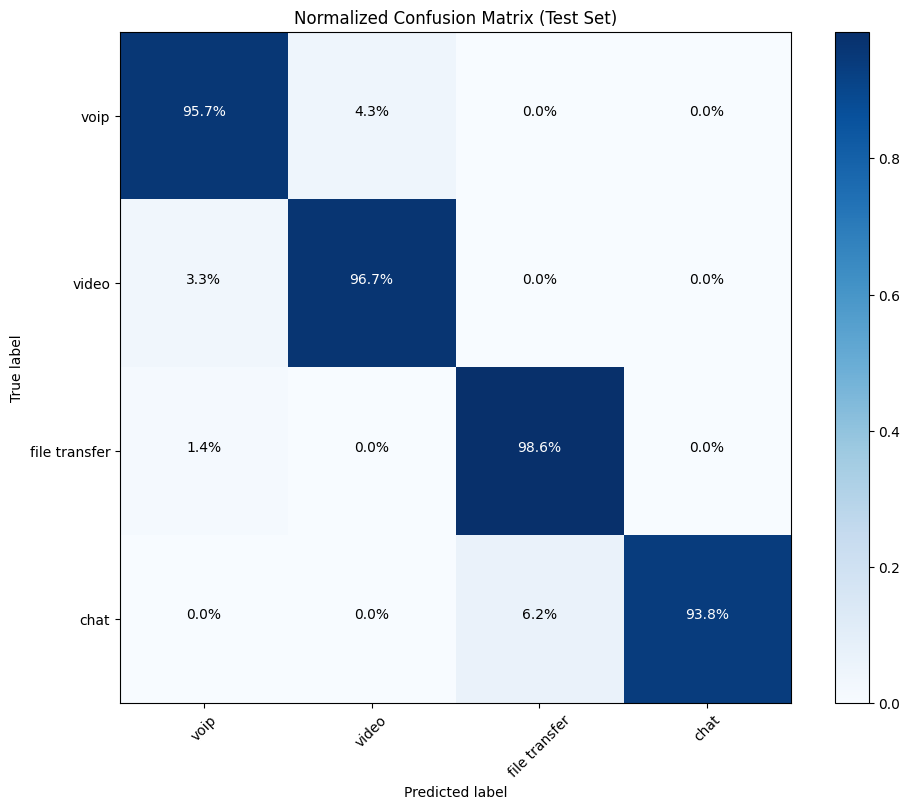


Test Accuracy: 0.9716


In [34]:
start_test_time = time.time()

# Get predictions
y_test_pred = model.predict(X_test,verbose=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

infrence_time = time.time() - start_test_time 
print(f'Total training time: {timedelta(seconds=infrence_time)}')


# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_true, y_test_pred_classes, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_true, y_test_pred_classes)
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                     title='Normalized Confusion Matrix (Test Set)')
plt.show()

# Print overall accuracy
accuracy = np.mean(y_test_pred_classes == y_test_true)
print(f"\nTest Accuracy: {accuracy:.4f}")